<a href="https://colab.research.google.com/github/amdihsann/Hotel-Review-Classification-and-Summarization/blob/main/classification_and_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===================================================================================
# PROYEK PORTOFOLIO DATA: ANALISIS 360° ULASAN HOTEL
#
# OBJECTIVE: Mengubah ulasan kualitatif menjadi dashboard intelijen bisnis
#            untuk pengambilan keputusan strategis oleh manajemen hotel.
#
# METHODOLOGY: 3-Layered AI Analysis
# 1. General Sentiment Analysis (The "What")
# 2. Aspect-Based Topic Classification (The "Why")
# 3. Intelligent Summarization for Escalation (The "Action Point")
# ===================================================================================


#1. INSTALLASION

In [ ]:
# 'transformers' untuk model AI, 'accelerate' untuk optimasi, 'wordcloud' untuk EDA
!pip install transformers accelerate wordcloud -q

In [ ]:
!pip install adjustText

In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from transformers import pipeline
import torch

#2. DATA FOUNDATION

In [ ]:
# URL dari dataset di GitHub
url = "https://raw.githubusercontent.com/amdihsann/Dataset-/refs/heads/main/Classification_hotel_review/tripadvisor_hotel_reviews.csv"

# Membaca file CSV ke dalam DataFrame Pandas
df = pd.read_csv(url)

##1) Data Cleaning

In [ ]:
# Cek dan hapus duplikat
initial_rows = len(df)
df.drop_duplicates(inplace=True)
print(f"- Menghapus {initial_rows - len(df)} baris duplikat.")


- Menghapus 0 baris duplikat.


In [ ]:
# Cek dan hapus nilai yang hilang (missing values) di kolom 'Review'
initial_rows = len(df)
df.dropna(subset=['Review'], inplace=True)
print(f"- Menghapus {initial_rows - len(df)} baris dengan ulasan kosong.")


- Menghapus 0 baris dengan ulasan kosong.


In [ ]:
# Reset index setelah menghapus baris
df.reset_index(drop=True, inplace=True)
print(f"- Ukuran data setelah cleaning: {df.shape}")

- Ukuran data setelah cleaning: (20491, 2)


In [ ]:
print("\nLima baris pertama data:")
display(df.head())


Lima baris pertama data:


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
print("\nInformasi Dataset:")
df.info()


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


##2) Exploratory Data Analysis (EDA)

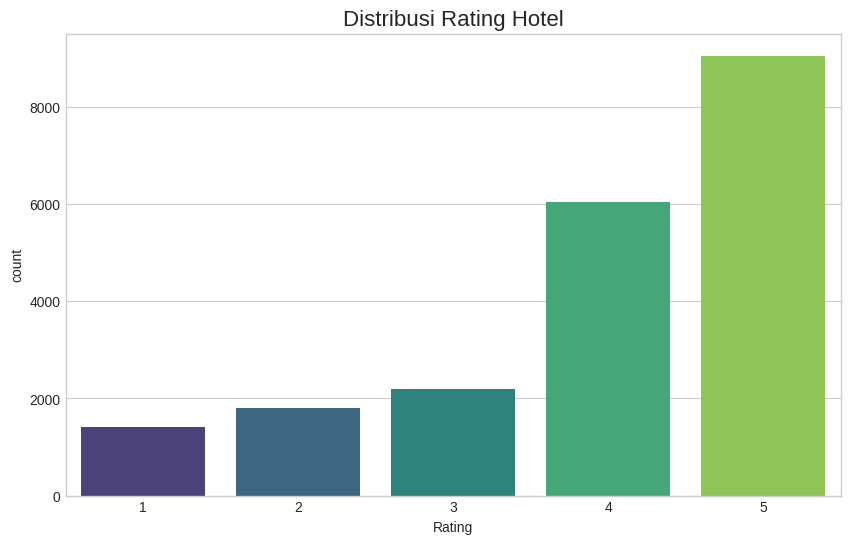

In [ ]:
# Visualisasi distribusi rating
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Rating', palette='viridis')
plt.title('Distribusi Rating Hotel', fontsize=16)
plt.show()

- Membuat Word Cloud dari seluruh ulasan...


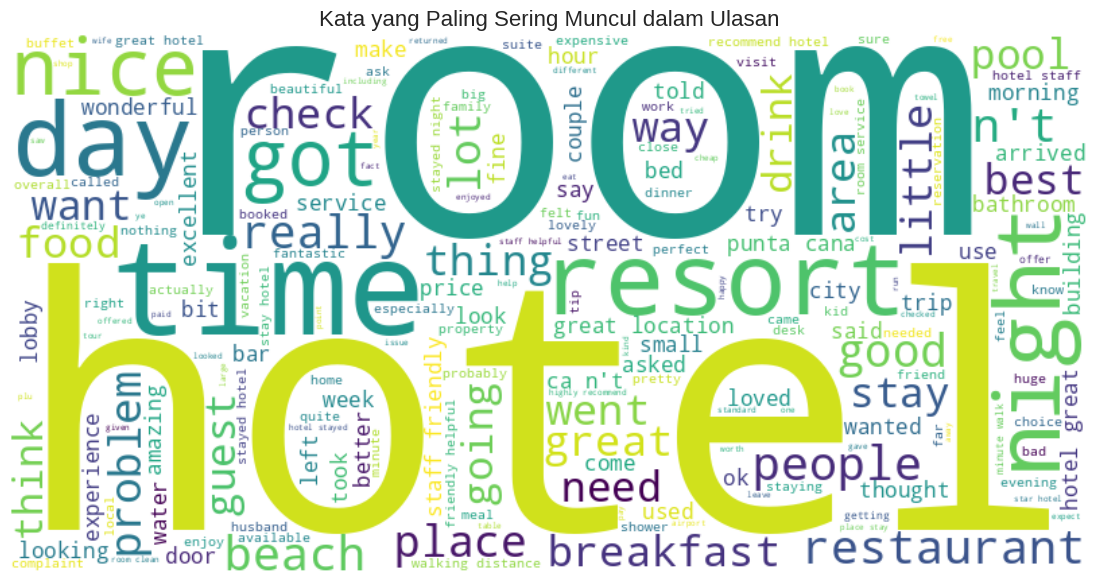

In [ ]:
# Membuat Word Cloud untuk melihat kata yang paling sering muncul
print("- Membuat Word Cloud dari seluruh ulasan...")
all_reviews_text = ' '.join(df['Review'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Kata yang Paling Sering Muncul dalam Ulasan', fontsize=16)
plt.show()

In [ ]:
SAMPLE_SIZE = 100
df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
print(f"\n🔥 BEKERJA DENGAN SAMPEL {SAMPLE_SIZE} BARIS UNTUK ANALISIS AI 🔥")


🔥 BEKERJA DENGAN SAMPEL 100 BARIS UNTUK ANALISIS AI 🔥


#3. ANALISIS AI MULTI-LAPIS

##1) Lapis 1: Analisis Sentimen Umum (Positif, Negatif, Netral)

In [ ]:
# print("\nLapis 1: Menjalankan Analisis Sentimen...")
# sentiment_pipeline = pipeline(
#     model="cardiffnlp/twitter-roberta-base-sentiment-latest",
#     task="sentiment-analysis",
#     device=0 if torch.cuda.is_available() else -1 # Gunakan GPU jika ada
# )
# # Menggunakan model ini karena dilatih untuk 3 kelas (pos, neg, neu)

In [ ]:
# # Fungsi untuk menerapkan pipeline ke list of reviews
# def get_sentiments(reviews):
#     results = sentiment_pipeline(reviews, truncation=True, max_length=512, padding=True)
#     return [res['label'] for res in results]

# df_sample['sentiment'] = get_sentiments(df_sample['Review'].tolist())
# # Mengubah label agar lebih mudah dibaca
# df_sample['sentiment'] = df_sample['sentiment'].replace({'LABEL_2': 'positive', 'LABEL_1': 'neutral', 'LABEL_0': 'negative'})

# print("✅ Analisis Sentimen selesai.")
# display(df_sample[['Review', 'Rating', 'sentiment']].head())

In [ ]:
# print("Membuat tabel perbandingan untuk heatmap...")
# comparison_table = pd.crosstab(df_sample['Rating'], df_sample['sentiment'])

# # Tampilkan tabelnya untuk melihat hasilnya sebelum divisualisasikan
# print("Tabel Perbandingan Rating vs. Sentimen:")
# display(comparison_table)

##2) Lapis 2: Klasifikasi Topik/Aspek

In [ ]:
# # Kita gunakan model instruct dari Google yang serbaguna dan ukurannya pas untuk Colab
# classifier = pipeline(
#     "text2text-generation",
#     model="google/flan-t5-base",
#     device=0 if torch.cuda.is_available() else -1
# )

In [ ]:
# # Definisikan topik yang ingin kita lacak (dalam Bahasa Inggris dan lebih detail)
# defined_topics = [
#     'Staff & Service',
#     'Cleanliness',
#     'Room & Amenities', # Mencakup fasilitas di dalam kamar
#     'Hotel Facilities', # Mencakup fasilitas umum seperti kolam renang, gym
#     'Location',
#     'Value for Money',
#     'Food & Beverage',
#     'Check-in/Check-out Process',
#     'Noise Level',
# ]

In [ ]:
# # Fungsi untuk mengklasifikasikan topik menggunakan prompting
# def get_topics(review):
#     prompt = f"""
#     As an expert hotel review analyst, you must follow these steps precisely:
#     1.  **Analyze the Review**: Read the hotel review provided below.
#     2.  **Identify Topics**: Identify up to two of the most relevant topics from this specific list: {', '.join(defined_topics)}.
#     3.  **Validate Topics**: Only assign topics that are explicitly mentioned in the review. Do not guess or add topics that are not there.
#     4.  **Format Output**: Provide your answer ONLY as a unique, comma-separated list. If no topics fit, answer with only 'General Experience'.

#     Review: "{review}"
#     Identified Topics:
#     """
#     try:
#         # Menghasilkan teks topik dari model
#         result_text = classifier(prompt, max_length=50)[0]['generated_text']
#         # Membersihkan output
#         topics = [topic.strip() for topic in result_text.split(',') if topic.strip() in defined_topics]
#         unique_topics = list(set(topics))
#         return unique_topics if unique_topics else ["General Experience"]
#     except Exception as e:
#         print(f"Error processing review: {e}")
#         return ["Error"]

In [ ]:
# # Terapkan fungsi ini. Ini adalah bagian yang paling lambat.
# df_sample['topics'] = df_sample['Review'].apply(get_topics)

# print("✅ Klasifikasi Topik selesai.")


In [ ]:
# display(df_sample[['Review', 'sentiment', 'topics']].head())

##3) Lapis 3: Summarization Cerdas untuk Eskalasi

In [ ]:
# ======================================================================
# PROFESSIONAL REVIEW ANALYSIS SYSTEM (FINAL FIXED VERSION)
# ======================================================================
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import pandas as pd
import re
import numpy as np
import warnings
from typing import List, Dict
from tqdm.auto import tqdm
import gc
warnings.filterwarnings('ignore')

class ProfessionalReviewAnalysisSystem:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        if self.verbose:
            print(f"🚀 Initializing System on device: {self.device}")
        self.model_configs = self._get_model_configurations()
        self.models = self._initialize_models()
        self._setup_linguistic_patterns()
        if self.verbose:
            print("✅ System initialization complete.")

    def _get_model_configurations(self) -> Dict:
        return {
            'summarization_models': [
                {'name': 'facebook/bart-large-cnn', 'priority': 1, 'max_length': 1024, 'optimal_summary_length': (40, 150)},
                {'name': 'google/pegasus-xsum', 'priority': 2, 'max_length': 512, 'optimal_summary_length': (30, 120)},
            ],
            'sentiment_models': [
                # Ganti ke model yang lebih pas buat review hotel
                {'name': 'nlptown/bert-base-multilingual-uncased-sentiment', 'priority': 1, 'labels': {0:'very negative',1:'negative',2:'neutral',3:'positive',4:'very positive'}}
            ]
        }

    def _initialize_models(self) -> Dict:
        models = {'summarization': None, 'sentiment': None}

        # Load Summarization Model
        if self.verbose: print("\n📚 Loading Summarization Model...")
        for config in self.model_configs['summarization_models']:
            try:
                if self.verbose: print(f"  🔄 Trying {config['name']}...")
                tokenizer = AutoTokenizer.from_pretrained(config['name'])
                model = AutoModelForSeq2SeqLM.from_pretrained(config['name'],
                    torch_dtype=torch.float16 if self.device == 'cuda' else torch.float32).to(self.device)
                models['summarization'] = {'tokenizer': tokenizer, 'model': model, 'config': config}
                if self.verbose: print(f"  ✅ Successfully loaded {config['name']}")
                break
            except Exception as e:
                if self.verbose: print(f"  ❌ Failed to load {config['name']}: {str(e)[:100]}")
                gc.collect(); torch.cuda.empty_cache()

        # Load Sentiment Model
        if self.verbose: print("\n🎭 Loading Sentiment Model...")
        for config in self.model_configs['sentiment_models']:
            try:
                if self.verbose: print(f"  🔄 Trying {config['name']}...")
                pipeline_instance = pipeline("sentiment-analysis", model=config['name'],
                    device=0 if self.device == "cuda" else -1)
                models['sentiment'] = {'pipeline': pipeline_instance, 'config': config}
                if self.verbose: print(f"  ✅ Successfully loaded {config['name']}")
                break
            except Exception as e:
                if self.verbose: print(f"  ❌ Failed to load {config['name']}: {str(e)[:100]}")

        if models['summarization'] is None: raise RuntimeError("Fatal: Could not load any summarization model.")
        if models['sentiment'] is None: raise RuntimeError("Fatal: Could not load any sentiment model.")
        return models

    def _setup_linguistic_patterns(self):
        self.hotel_aspects = {
            'Staff & Service': ['staff', 'service', 'reception', 'friendly', 'rude'],
            'Cleanliness': ['clean', 'dirty', 'spotless', 'hygiene'],
            'Room & Amenities': ['room', 'suite', 'bed', 'bathroom', 'shower', 'view', 'balcony', 'ac'],
            'Hotel Facilities': ['pool', 'gym', 'spa', 'parking', 'facility'],
            'Location': ['location', 'area', 'nearby', 'downtown', 'convenient'],
            'Value for Money': ['price', 'value', 'expensive', 'cheap', 'worth'],
            'Food & Beverage': ['food', 'breakfast', 'dinner', 'restaurant', 'buffet'],
            'Check-in/Check-out Process': ['check-in', 'check-out', 'reception', 'counter', 'queue'],
            'Noise Level': ['noise', 'quiet', 'loud', 'sound']
        }

    def extract_topics(self, text: str) -> List[str]:
        text_lower = text.lower()
        mentioned_aspects = [topic for topic, keywords in self.hotel_aspects.items()
                             if any(keyword in text_lower for keyword in keywords)]
        return mentioned_aspects if mentioned_aspects else ['General']

    def analyze_sentiment(self, text: str) -> Dict:
        try:
            pipeline = self.models['sentiment']['pipeline']
            result = pipeline(text[:512])[0]  # ambil 512 token pertama
            label = result['label']
            # Map ke pos/neg/neutral
            if label in ['1 star', '2 stars']:
                sentiment = 'negative'
            elif label == '3 stars':
                sentiment = 'neutral'
            elif label in ['4 stars', '5 stars']:
                sentiment = 'positive'
            else:
                sentiment = 'neutral'
            return {'sentiment': sentiment, 'confidence': result['score']}
        except Exception:
            return {'sentiment': 'neutral', 'confidence': 0.5}

    def summarize(self, text: str) -> str:
        try:
            tokenizer = self.models['summarization']['tokenizer']
            model = self.models['summarization']['model']
            config = self.models['summarization']['config']

            inputs = tokenizer(text, max_length=config['max_length'],
                               return_tensors="pt", truncation=True).to(self.device)
            min_len, max_len = config['optimal_summary_length']

            with torch.no_grad():
                summary_ids = model.generate(inputs["input_ids"],
                    max_length=max_len, min_length=min_len,
                    num_beams=4, repetition_penalty=2.0,
                    no_repeat_ngram_size=2, early_stopping=True)
            summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
            return summary
        except Exception:
            return text[:120] + "..." # fallback

    def create_executive_summary(self, summaries: List[str], sentiment_type: str) -> str:
        if not summaries:
            return f"No valid {sentiment_type} reviews to summarize."

        # Bersihkan dan deduplikasi
        clean_summaries = []
        for s in summaries:
            s = re.sub(r'[^a-zA-Z0-9 .,]', '', s)
            if len(s.split()) > 4 and s not in clean_summaries:
                clean_summaries.append(s)

        if not clean_summaries:
            return f"No valid {sentiment_type} reviews to summarize."

        # Gabungkan menjadi executive summary
        combined_text = " ".join(clean_summaries[:10])  # ambil 10 ringkasan pertama
        final_summary = self.summarize(combined_text)
        return final_summary

    def run_analysis(self, dataframe: pd.DataFrame, review_column: str = 'Review') -> pd.DataFrame:
        if self.verbose: print(f"\n🚀 Running full analysis on {len(dataframe)} reviews...")
        results = []
        for index, row in tqdm(dataframe.iterrows(), total=len(dataframe), desc="Analyzing Reviews"):
            text = row[review_column]
            if not isinstance(text, str) or not text.strip(): continue

            sentiment_data = self.analyze_sentiment(text)
            topics = self.extract_topics(text)
            summary = self.summarize(text)

            results.append({
                'review': text,
                'rating': row.get('Rating', None),
                'sentiment': sentiment_data['sentiment'],
                'confidence': sentiment_data['confidence'],
                'topics': topics,
                'summary': summary,
                'is_sarcastic': False  # placeholder
            })

        if self.verbose: print("✅ Analysis pipeline complete!")
        return pd.DataFrame(results)


In [ ]:
# ======================================================================
# CARA MENJALANKAN SISTEM ANALISIS (DENGAN KOREKSI)
# ======================================================================

# Pastikan DataFrame 'df' sudah dimuat
# df_sample = df.sample(n=100, random_state=42)

# 1. Inisialisasi Sistem
try:
    analyzer = ProfessionalReviewAnalysisSystem(verbose=True)
except Exception as e:
    print(f"❌ GAGAL INISIALISASI SISTEM: {e}")
    analyzer = None

# 2. Jalankan Analisis Jika Inisialisasi Berhasil
if analyzer:
    df_results = analyzer.run_analysis(df_sample)

    # --- PERBAIKAN KETIGA DI SINI ---
    # Menampilkan hasil dengan nama kolom huruf kecil
    from IPython.display import HTML, display
    print("\n" + "="*40)
    print("     HASIL ANALISIS PER BARIS (LEVEL 1)")
    print("="*40)
    display(HTML(df_results[['review', 'rating', 'sentiment', 'is_sarcastic', 'topics', 'summary']].head(10).to_html()))

    # 3. Menjalankan Analisis Level 2 (Executive Summary)
    # --- PERBAIKAN KEEMPAT DI SINI ---
    # Menggunakan nama kolom dan nilai huruf kecil
    positive_summaries = df_results[df_results['sentiment'] == 'positive']['summary'].tolist()
    negative_summaries = df_results[df_results['sentiment'] == 'negative']['summary'].tolist()
    neutral_summaries = df_results[df_results['sentiment'] == 'neutral']['summary'].tolist()

    summary_positive = analyzer.create_executive_summary(positive_summaries, "positive")
    summary_negative = analyzer.create_executive_summary(negative_summaries, "negative")
    summary_neutral = analyzer.create_executive_summary(neutral_summaries, "neutral")

    print("\n" + "="*40)
    print("     KESIMPULAN UTAMA (LEVEL 2 - EXECUTIVE SUMMARY)")
    print("="*40)
    print("\n✨ TEMA UTAMA DARI ULASAN POSITIF:")
    print(summary_positive)
    print("\n🔥 TEMA UTAMA DARI ULASAN NEGATIF:")
    print(summary_negative)
    print("\n💡 INSIGHT EMAS DARI ULASAN NETRAL:")
    print(summary_neutral)

🚀 Initializing System on device: cpu

📚 Loading Summarization Model...
  🔄 Trying facebook/bart-large-cnn...
  ✅ Successfully loaded facebook/bart-large-cnn

🎭 Loading Sentiment Model...
  🔄 Trying nlptown/bert-base-multilingual-uncased-sentiment...


Device set to use cpu


  ✅ Successfully loaded nlptown/bert-base-multilingual-uncased-sentiment
✅ System initialization complete.

🚀 Running full analysis on 100 reviews...


Analyzing Reviews:   0%|          | 0/100 [00:00<?, ?it/s]

✅ Analysis pipeline complete!

     HASIL ANALISIS PER BARIS (LEVEL 1)


,review,rating,sentiment,is_sarcastic,topics,summary
0,"not recommend hotel did reviewers actually stay hotel did, good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got, disgusting, staff rude complained left night early refused refund night, not recommend hotel,",1,negative,False,"[Staff & Service, Cleanliness, Room & Amenities, Location]","not recommend hotel did reviewers actually stay at hotel? Good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got. Staff rude complained left night early refused refund night, not recommend Hotel."
1,"barcelona rocks, stayed hotel jazz girlfriend 3 nights end august.the hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds, caught airport bus barcelona costs 7 euros person return trip, hotel located 2 mins walk maximum placa universitat stop 2nd route, hotel modern clean, air conditioning room superb balcony looking street outside, room good size, bathroom fine scrimp bit toiletries, bring shower gels unless consider washing unnecessary luxury travels.the downside hotel possibly strengths depending viewpoint, hotel superbly situated 2 different metro stations extremely handy need city sights, downside feel rumbling trains hotel 3rd floor located, worse incessant sound taxi horns hotel mela times square nyc ca n't say disturbed consideration light sleepers irritation, couple shops hotel useful snacks drinks want avoid minibar prices, pool roof tiny n't recommend booking pretty nice place kill time particularly check day just wanted sit chill, n't expect able sit night, shuts fairly early.the hotel excellent 3 star property suggest prices pretty 4 star level, aside hotel tourist bus stopped directly opposite room recommend good way getting overview timer city want possible different areas, think used barcelona tours continuous loop alternative bus turistic 3 different loops involves changing bus round different areas.see gaudi, no fan architecture means, parc guell worth visit nice day n't mind walking uphill, sagrada familia outstanding, couple boat tours port harbour, personally bit underwhelming, save time money things.the nou camp tour worth visit no fan football, stadium amazing history club fascinating, plans redevelopment spectacle completed.ignore negative websites sprung make barcelona akin early days wild west, n't, just sensible major city, read ludicrous claims mark target muggers/pickpockets wore shorts/looked map/did n't speak spanish, rubbish, area ramblas felt safe, couple areas lower end raval little seedy late night just n't stupid fine, worst crime encountered charged 10 euros 2 heinekens irish bar just ramblas heard no-one eats restaurants 9 suffer lack atmosphere did, did n't appear strictly true concede 3 nights, tell restaurants open 8-8.30pm worth getting avoid queues, saturday night arrived restaurant 8.30 offered seat terrace opting window seat overlooking ramblas, 9 turning people away, 9.45 taken pick tables, burst activity 9 n't bad.enjoy,",4,positive,False,"[Cleanliness, Room & Amenities, Hotel Facilities, Location, Value for Money, Food & Beverage, Check-in/Check-out Process, Noise Level]","Barcelona rocks, stayed hotel jazz girlfriend 3 nights end august. The hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed respite mayhem crowds. Hotel superbly situated 2 different metro stations extremely handy need city sights."
2,"ok hotel good location stayed night way beijing rawa island, hotel service room ok. location great shopping restaurants, probably stay, opinion nice 3 star hotel,",3,neutral,False,"[Staff & Service, Room & Amenities, Location, Food & Beverage]","ok hotel good location stayed night way beijing rawa island, hotel service room ok. locati


     KESIMPULAN UTAMA (LEVEL 2 - EXECUTIVE SUMMARY)

✨ TEMA UTAMA DARI ULASAN POSITIF:
Barcelona rocks, stayed hotel jazz girlfriend 3 nights end august. The hotel excellent location carrer pelai, close placa catalunya ramblas appreciate buzz city removed mayhem crowds. Hotel superbly situated 2 different metro stations extremely handy need city sights. great service nice pool ok beach lovely grounds small rooms stayed 5 days 4 nights 1st 5th.

🔥 TEMA UTAMA DARI ULASAN NEGATIF:
not recommend hotel did reviewers actually stay at hotel Good thing hotel location really close leidseplein, shared facilities filthy got, did not look toilet floor cleaned month, facilities not cleaned 3 days got. Staff rude complained left night early refused refund night, not recommend Hotel. par price stayed marco polo hotel 1 night november 18 19 time, check quick efficient got room no light working called reception, person housekeeping arrived 5 minutes later. Room large separate pantry oldfashioned worn 

#4. SINTESIS & VISUALISASI (PRIORITY MATRIX)

##1) Persiapan Data untuk Matriks

In [ ]:
# # Menghapus topik yang tidak relevan
# df_exploded = df_exploded[~df_exploded['topics'].isin(['Lainnya', 'Error'])]

In [ ]:
# # Memberi skor numerik pada sentimen
# sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
# df_exploded['sentiment_score'] = df_exploded['sentiment'].map(sentiment_map)


In [ ]:
# # Agregasi data: hitung frekuensi dan rata-rata sentimen per topik
# matrix_data = df_exploded.groupby('topics').agg(
#     frequency=('topics', 'size'),
#     avg_sentiment=('sentiment_score', 'mean')
# ).reset_index()

# print("\nData Agregat untuk Matriks Prioritas:")
# display(matrix_data)

##2) Visualisasi Matriks Prioritas

In [ ]:
# # Import library baru di bagian atas sel
# from adjustText import adjust_text

# # Cek dulu apakah matrix_data tidak kosong
# if not matrix_data.empty:
#     # --- KODE GRAFIK MATRIKS PRIORITAS BARU ---

#     plt.style.use('seaborn-v0_8-whitegrid')
#     # Ukuran gambar sedikit diperbesar untuk memberi lebih banyak ruang
#     fig, ax = plt.subplots(figsize=(14, 9))

#     # Scatter plot (bagian ini tidak berubah)
#     sns.scatterplot(data=matrix_data, x='avg_sentiment', y='frequency', hue='topics', s=250, ax=ax, legend=False)

#     # --- PERBAIKAN DIMULAI DI SINI ---

#     # 1. Alih-alih langsung menggambar teks, kita kumpulkan dulu objek teksnya ke dalam sebuah list
#     texts = []
#     for i, row in matrix_data.iterrows():
#         texts.append(ax.text(row['avg_sentiment'], row['frequency'], row['topics'], fontsize=12, ha='center'))

#     # 2. Panggil fungsi adjust_text untuk mengatur posisi semua teks secara otomatis agar tidak tumpang tindih
#     adjust_text(
#         texts,
#         arrowprops=dict(arrowstyle='->', color='grey', lw=0.5) # Tambahkan panah jika teks digeser jauh
#     )

#     # --- AKHIR DARI PERBAIKAN ---

#     # Kode untuk garis kuadran dan anotasi (tidak ada yang berubah)
#     avg_sent_median = matrix_data['avg_sentiment'].median()
#     freq_median = matrix_data['frequency'].median()

#     ax.axhline(freq_median, color='grey', linestyle='--')
#     ax.axvline(avg_sent_median, color='grey', linestyle='--')

#     plt.text(avg_sent_median + 0.02, freq_median * 1.1, 'Kekuatan Utama\n(Sering Dipuji)', color='green', fontsize=12, ha='left')
#     plt.text(avg_sent_median - 0.02, freq_median * 1.1, 'KRITIS: PERBAIKI SEKARANG!\n(Sering Dikeluhkan)', color='red', fontsize=12, ha='right')
#     plt.text(avg_sent_median - 0.02, freq_median * 0.9, 'Risiko Tersembunyi\n(Jarang Dikeluhkan)', color='orange', fontsize=12, ha='right', va='top')
#     plt.text(avg_sent_median + 0.02, freq_median * 0.9, 'Peluang\n(Jarang Dipuji)', color='blue', fontsize=12, ha='left', va='top')

#     ax.set_title('Dashboard Matriks Prioritas Hotel', fontsize=20, pad=20)
#     ax.set_xlabel('Rata-rata Sentimen (Negatif -> Positif)', fontsize=14)
#     ax.set_ylabel('Frekuensi Pembicaraan', fontsize=14)

#     plt.show()

# else:
#     print("\nTidak cukup data topik untuk membuat matriks prioritas. Coba perbesar SAMPLE_SIZE.")

In [ ]:
# # Menghitung berapa kali setiap topik muncul
# df_sample.explode('topics')['topics'].value_counts()

In [ ]:
# # Pastikan Anda sudah memiliki tabel perbandingan dari langkah sebelumnya
# # Nama variabelnya bisa 'comparison' atau 'comparison_table' dari pd.crosstab()
# # Contoh: comparison_table = pd.crosstab(df_sample['Rating'], df_sample['sentiment'])

# # --- KODE HEATMAP BARU ---

# # Mengatur ukuran gambar agar lebih besar dan tidak sempit
# plt.figure(figsize=(12, 8))

# # Membuat heatmap dengan parameter tambahan untuk kejelasan
# sns.heatmap(
#     comparison_table,       # Gunakan tabel hasil crosstab Anda
#     annot=True,             # Tampilkan angka di dalam kotak (anotasi)
#     fmt='d',                # Format angka sebagai integer (bukan desimal)
#     cmap='coolwarm',        # Skema warna yang Anda gunakan sebelumnya
#     linewidths=.5,          # Beri garis tipis antar kotak agar terpisah
#     annot_kws={"size": 14}  # ATUR UKURAN FONT angka di dalam kotak agar mudah dibaca
# )

# # Menambahkan judul dan label dengan font yang lebih jelas dan padding
# plt.title('Heatmap: Hubungan Rating Pengguna vs. Sentimen AI', fontsize=18, pad=20)
# plt.xlabel('Sentimen Prediksi AI', fontsize=12)
# plt.ylabel('Rating Diberikan Pengguna', fontsize=12)

# # Tampilkan plot
# plt.show()


Data Agregat untuk Matriks Prioritas:


,topics,frequency,avg_sentiment
0,Check-in/Check-out Process,21,0.238095
1,Cleanliness,56,0.500000
2,Food & Beverage,71,0.521127
3,Hotel Facilities,47,0.553191
4,Location,60,0.516667
5,Noise Level,33,0.606061
6,Room & Amenities,98,0.459184
7,Staff & Service,82,0.414634
8,Value for Money,41,0.439024


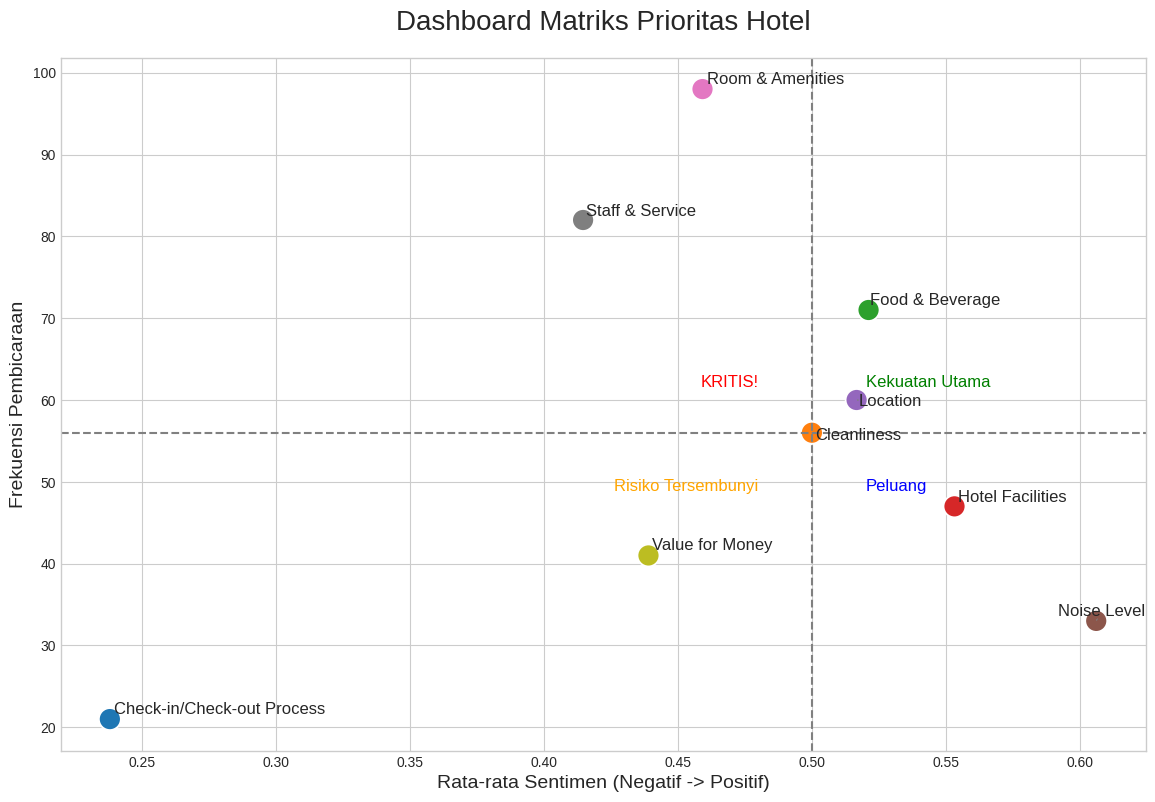

In [ ]:
# ======================================================================
# PERSIAPAN DATA & VISUALISASI
# ======================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

if 'df_results' in locals():
    # --- PERSIAPAN DATA UNTUK PRIORITY MATRIX ---
    # 1. Explode topics list
    df_exploded = df_results.explode('topics')

    # 2. Map sentiment to score
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}
    df_exploded['sentiment_score'] = df_exploded['sentiment'].map(sentiment_map)

    # 3. Aggregate data
    matrix_data = df_exploded.groupby('topics').agg(
        frequency=('topics', 'size'),
        avg_sentiment=('sentiment_score', 'mean')
    ).reset_index()
    print("\nData Agregat untuk Matriks Prioritas:")
    display(matrix_data)

    # --- MEMBUAT GRAFIK PRIORITY MATRIX ---
    if not matrix_data.empty:
        plt.style.use('seaborn-v0_8-whitegrid')
        fig, ax = plt.subplots(figsize=(14, 9))
        sns.scatterplot(data=matrix_data, x='avg_sentiment', y='frequency', hue='topics', s=250, ax=ax, legend=False)

        texts = [ax.text(row['avg_sentiment'], row['frequency'], row['topics'], fontsize=12) for i, row in matrix_data.iterrows()]
        adjust_text(texts, arrowprops=dict(arrowstyle='->', color='grey', lw=0.5))

        # (Sisa kode visualisasi untuk garis dan label kuadran tidak berubah)
        avg_sent_median = matrix_data['avg_sentiment'].median()
        freq_median = matrix_data['frequency'].median()
        ax.axhline(freq_median, color='grey', linestyle='--'); ax.axvline(avg_sent_median, color='grey', linestyle='--')
        plt.text(avg_sent_median + 0.02, freq_median * 1.1, 'Kekuatan Utama', color='green', fontsize=12, ha='left')
        plt.text(avg_sent_median - 0.02, freq_median * 1.1, 'KRITIS!', color='red', fontsize=12, ha='right')
        plt.text(avg_sent_median - 0.02, freq_median * 0.9, 'Risiko Tersembunyi', color='orange', fontsize=12, ha='right', va='top')
        plt.text(avg_sent_median + 0.02, freq_median * 0.9, 'Peluang', color='blue', fontsize=12, ha='left', va='top')
        ax.set_title('Dashboard Matriks Prioritas Hotel', fontsize=20, pad=20)
        ax.set_xlabel('Rata-rata Sentimen (Negatif -> Positif)', fontsize=14)
        ax.set_ylabel('Frekuensi Pembicaraan', fontsize=14)
        plt.show()
else:
    print("\nTidak ada cukup data untuk membuat matriks prioritas.")